## DASK

In [1]:
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
import dask.dataframe as dd
import dask
import pandas as pd

In [2]:
pbar = ProgressBar()
pbar.register()

In [2]:
cluster = LocalCluster(n_workers=1, threads_per_worker=1, memory_limit="4GB")
client = Client(cluster)

2022-08-08 15:17:26,714 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-l5ljdso6', purging


In [3]:
dfe = dd.read_csv('../products/raw/embeddings.csv',header=None)
df = pd.read_csv('../products/production_metadata/metadata_full.csv', dtype={'pubmed_id':str,'arxiv_id':str, 'who_covidence_id':str})

/tmp/ipykernel_51678/3112780370.py:2: DtypeWarning: Columns (2,5,6,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../products/production_metadata/metadata_full.csv', dtype={'pubmed_id':str,'arxiv_id':str, 'who_covidence_id':str})


In [4]:
dfe = dfe.reset_index(drop=True)

In [5]:
df.drop('Unnamed: 0',axis=1, inplace=True)

In [6]:
df.set_index('cord_uid',inplace=True)

In [7]:
dfe = dfe[dfe.iloc[:,0].isin(df.index)]

In [8]:
dfe = dfe.rename(columns={0:'cord_uid'})

In [9]:
dfe = dfe.drop_duplicates(subset=['cord_uid'])

In [10]:
dfe = dfe.set_index('cord_uid').persist()

[########################################] | 100% Completed | 558.75 s
[####################################### ] | 99% Completed | 340.10 s

IOStream.flush timed out


[########################################] | 100% Completed | 430.31 s


In [11]:
dfe = dfe.repartition(npartitions=100)

In [16]:
from dask_ml.cluster import KMeans
from dask_ml.preprocessing import StandardScaler

In [26]:
dfe.head()

[########################################] | 100% Completed | 102.43 ms


,1,2,3,4,5,6,7,8,9,10,...,760,761,762,763,764,765,766,767,768,labels
cord_uid,,,,,,,,,,,,,,,,,,,,,
0004vg0m,1.003851,1.126651,-0.188615,-1.444257,1.000858,0.388225,1.912646,-1.386552,0.077573,0.127358,...,-1.323385,-0.976276,1.479211,0.694058,0.375922,1.509289,0.649065,-0.615997,-0.717369,3
0004vms8,0.711630,1.043547,0.461836,-1.855910,-0.402304,1.029285,-1.138418,-1.093904,0.912397,0.755210,...,-0.341992,1.030085,0.499977,-0.009433,0.494047,1.216069,0.465910,-0.204784,2.596523,3
0005g7qw,0.192610,0.777227,-1.234849,-1.862522,0.454213,2.263359,-0.617209,0.529465,0.557498,0.689200,...,-0.750716,-1.761006,0.341850,-0.303280,0.587455,1.068271,-0.140563,-0.639354,0.353755,0
000ahtxm,-0.335527,-1.785616,-0.842565,0.074523,-0.460675,0.365051,0.646810,0.377949,0.511304,-0.722833,...,0.227006,0.986836,-1.347869,-1.430335,1.420504,-0.126226,-0.716381,0.161684,1.311092,4
000ajevz,0.632303,0.823560,1.275644,0.659171,1.969654,0.351244,0.816139,0.785783,-0.250779,-0.041115,...,0.170975,1.804468,0.424102,-1.666296,-0.624987,-0.211175,0.818231,-1.584352,-0.811476,4


In [17]:
scaler = StandardScaler(copy=False)
dfe = scaler.fit_transform(dfe)

[########################################] | 100% Completed | 14.62 s


### Dask kmean

In [20]:
kmeanModel = KMeans(n_clusters=5,init='k-means||',init_max_iter=5,max_iter=200)
kmeanModel.fit(dfe)

[########################################] | 100% Completed | 2.74 sms
[########################################] | 100% Completed | 3.85 sms
[########################################] | 100% Completed | 101.87 ms
[########################################] | 100% Completed | 6.61 sms
[########################################] | 100% Completed | 6.93 ss
[########################################] | 100% Completed | 204.02 ms
[########################################] | 100% Completed | 7.27 ss
[########################################] | 100% Completed | 203.56 ms
[########################################] | 100% Completed | 7.23 ss
[########################################] | 100% Completed | 356.77 ms
[########################################] | 100% Completed | 9.79 ss
[########################################] | 100% Completed | 684.66 ms
[########################################] | 100% Completed | 9.57 ss
[########################################] | 100% Completed | 410.04 ms
[####

KMeans(init_max_iter=5, max_iter=200, n_clusters=5)

In [21]:
dfe['labels'] = kmeanModel.predict(dfe)

[########################################] | 100% Completed | 3.48 sms
[########################################] | 100% Completed | 3.93 sms


In [22]:
dfe[['labels']].head()

[########################################] | 100% Completed | 316.06 ms


,labels
cord_uid,
0004vg0m,3
0004vms8,3
0005g7qw,0
000ahtxm,4
000ajevz,4


In [23]:
from joblib import dump, load
dump(kmeanModel, './kmeanModel-00.joblib') 

['./kmeanModel-00.joblib']

In [52]:
dfe[['labels']].to_csv('./export/labels.csv', single_file=True)

[########################################] | 100% Completed | 23.62 s


['/home/frinve/Code/CovEffect-data-provision/notebooks/export/labels.csv']

In [30]:
df_meta = dd.merge(df, dfe[['labels']], how='inner', left_index=True, right_index=True)

In [36]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

In [37]:
def createWordCountFigure(lemmatized_data,max_df_thr):
    cv=CountVectorizer(analyzer='word',max_features=300,max_df=max_df_thr)
    data=cv.fit_transform(lemmatized_data)
    df_dtm_0 = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
    # Transposing document term matrix
    df_dtm_0 = df_dtm_0.transpose()
    #Create count vector
    df_dtm_0_count = df_dtm_0.sum(axis=1, skipna=True)
    df_dtm_0_count = df_dtm_0_count.to_frame().rename(columns={0:'count'})
    ## dict required for WC
    dict_dtm_0 = df_dtm_0_count.to_dict()['count']
    #print(dict_dtm_0)
    wc = WordCloud(width=1600, height=1200, max_words=150, colormap='Dark2').generate_from_frequencies(dict_dtm_0)
    return wc

In [38]:
def showWordCountPic(picture):
    plt.figure(figsize=(16,8))
    plt.imshow(picture, interpolation="bilinear")
    plt.axis("off")
    plt.show()

[########################################] | 100% Completed | 2.87 sms
[########################################] | 100% Completed | 505.98 ms
[########################################] | 100% Completed | 509.92 ms
[########################################] | 100% Completed | 1.11 sms
[########################################] | 100% Completed | 921.12 ms
[########################################] | 100% Completed | 317.80 ms
[########################################] | 100% Completed | 808.58 ms
[########################################] | 100% Completed | 712.38 ms
[########################################] | 100% Completed | 1.11 sms
[########################################] | 100% Completed | 708.81 ms
[########################################] | 100% Completed | 310.86 ms
[########################################] | 100% Completed | 608.24 ms
[########################################] | 100% Completed | 1.05 sms
[########################################] | 100% Completed | 315.02

/home/frinve/Code/CovEffect-data-provision/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


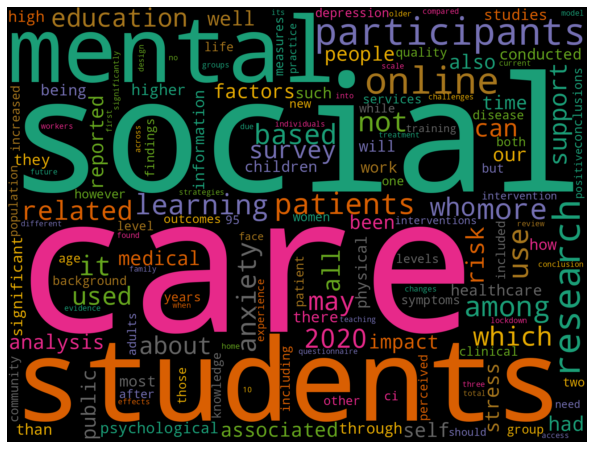

In [40]:
pic_0 = createWordCountFigure(df_meta[df_meta.labels==0]['abstract'],0.30)
showWordCountPic(pic_0)

[########################################] | 100% Completed | 624.01 ms
[########################################] | 100% Completed | 436.23 ms
[########################################] | 100% Completed | 852.48 ms
[########################################] | 100% Completed | 476.26 ms
[########################################] | 100% Completed | 556.29 ms
[########################################] | 100% Completed | 689.40 ms
[########################################] | 100% Completed | 817.33 ms
[########################################] | 100% Completed | 574.40 ms
[########################################] | 100% Completed | 583.70 ms
[########################################] | 100% Completed | 730.94 ms
[########################################] | 100% Completed | 494.64 ms
[########################################] | 100% Completed | 818.53 ms
[########################################] | 100% Completed | 851.09 ms
[########################################] | 100% Completed | 84

/home/frinve/Code/CovEffect-data-provision/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


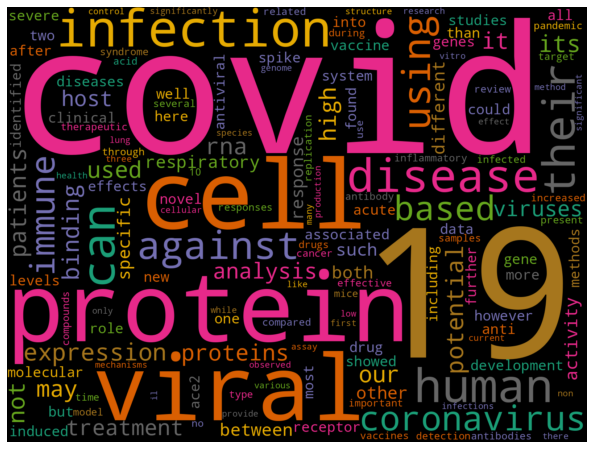

In [41]:
pic_1 = createWordCountFigure(df_meta[df_meta.labels==1]['abstract'],0.30)
showWordCountPic(pic_1)

[########################################] | 100% Completed | 407.23 ms
[########################################] | 100% Completed | 415.71 ms
[########################################] | 100% Completed | 303.71 ms
[########################################] | 100% Completed | 203.52 ms
[########################################] | 100% Completed | 304.77 ms
[########################################] | 100% Completed | 511.28 ms
[########################################] | 100% Completed | 203.34 ms
[########################################] | 100% Completed | 427.91 ms
[########################################] | 100% Completed | 203.09 ms
[########################################] | 100% Completed | 315.88 ms
[########################################] | 100% Completed | 415.54 ms
[########################################] | 100% Completed | 311.00 ms
[########################################] | 100% Completed | 343.23 ms
[########################################] | 100% Completed | 43

/home/frinve/Code/CovEffect-data-provision/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


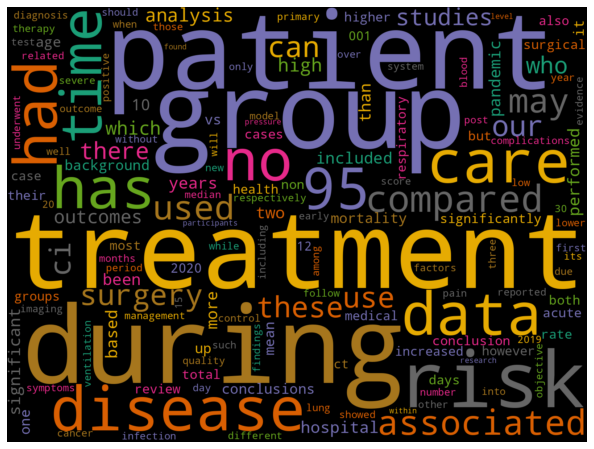

In [44]:
pic_2 = createWordCountFigure(df_meta[df_meta.labels==2]['abstract'],0.30)
showWordCountPic(pic_2)

[########################################] | 100% Completed | 202.84 ms
[########################################] | 100% Completed | 505.01 ms
[########################################] | 100% Completed | 202.99 ms
[########################################] | 100% Completed | 305.03 ms
[########################################] | 100% Completed | 203.40 ms
[########################################] | 100% Completed | 305.91 ms
[########################################] | 100% Completed | 304.33 ms
[########################################] | 100% Completed | 203.15 ms
[########################################] | 100% Completed | 409.46 ms
[########################################] | 100% Completed | 203.77 ms
[########################################] | 100% Completed | 404.12 ms
[########################################] | 100% Completed | 307.58 ms
[########################################] | 100% Completed | 203.16 ms
[########################################] | 100% Completed | 20

/home/frinve/Code/CovEffect-data-provision/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


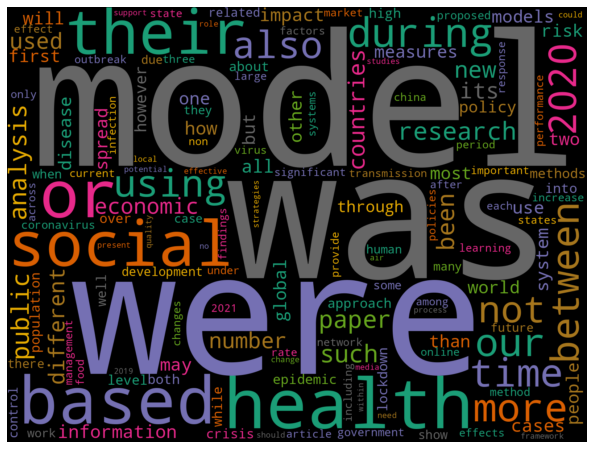

In [45]:
pic_3 = createWordCountFigure(df_meta[df_meta.labels==3]['abstract'],0.30)
showWordCountPic(pic_3)

[########################################] | 100% Completed | 410.17 ms
[########################################] | 100% Completed | 313.81 ms
[########################################] | 100% Completed | 209.44 ms
[########################################] | 100% Completed | 221.14 ms
[########################################] | 100% Completed | 310.56 ms
[########################################] | 100% Completed | 202.68 ms
[########################################] | 100% Completed | 204.21 ms
[########################################] | 100% Completed | 303.42 ms
[########################################] | 100% Completed | 303.88 ms
[########################################] | 100% Completed | 244.22 ms
[########################################] | 100% Completed | 406.11 ms
[########################################] | 100% Completed | 271.15 ms
[########################################] | 100% Completed | 262.55 ms
[########################################] | 100% Completed | 41

/home/frinve/Code/CovEffect-data-provision/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


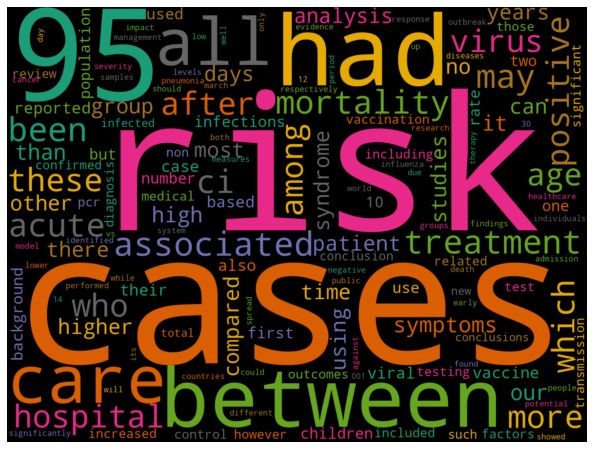

In [46]:
pic_4 = createWordCountFigure(df_meta[df_meta.labels==4]['abstract'],0.30)
showWordCountPic(pic_4)

In [48]:
df_meta['whole_text'] = df_meta['title'] + ' ' + df_meta['abstract']

In [49]:
df_meta.to_csv('./metadata_clustered.csv', single_file=True)

[########################################] | 100% Completed | 144.92 s


['/home/frinve/Code/CovEffect-data-provision/notebooks/metadata_clustered.csv']

In [51]:
dd.compute(df_meta[df_meta.labels==1].shape)

[########################################] | 100% Completed | 35.12 s


((135712, 24),)